# VGG16 и VGG19
Набор данных представляет собой простое медицинское
изображение в стиле MNIST размером 64x64.

Датасет описан в задании как содержащий 58954 медицинских изображений 64×64 пикселя, относящихся к 6 классам:

* КТ грудной клетки (10000)

* МРТ молочной железы (8954)

* CXR (10000)

* Руки (10000)

* КТ головы (10000)

* Брюшной полости (10000)

In [ ]:
!pip install tensorflow

## Распаковка из zip

In [ ]:
zip_path = '/content/Archive-VGG.zip'  # Укажи путь к архиву
extract_path = '/content/dataset'       # Куда распаковывать

In [ ]:
import zipfile
import os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Архив успешно распакован в:", extract_path)

Архив успешно распакован в: /content/dataset


### Загрузка изображений и формирование датасета

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

IMG_SIZE = 64
LIMIT_PER_CLASS = 500  # сколько изображений брать на класс

X = []
y = []

data_dir = extract_path  # путь к распакованному архиву
classes = sorted(os.listdir(data_dir))
num_classes = len(classes)

for label, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)[:LIMIT_PER_CLASS]  # ограничение
    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 64.0
            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Ошибка с {img_path}: {e}")

X = np.array(X)
y = to_categorical(np.array(y), num_classes=num_classes)

# Разделим выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=555)

print("✅ Данные успешно загружены:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


✅ Данные успешно загружены:
X_train shape: (2400, 64, 64, 3)
y_train shape: (2400, 6)
X_test shape: (600, 64, 64, 3)
y_test shape: (600, 6)


## Построение архитектуры модели

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

def create_model(arch='vgg16', optimizer='adam', lr=1e-4, dropout_rate=0.5):
    base = VGG16 if arch == 'vgg16' else VGG19
    base_model = base(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    if optimizer == 'adam':
        opt = Adam(learning_rate=lr)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=lr)
    else:
        raise ValueError("Неизвестный оптимизатор")

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Архитектура для исследования слоев

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from tensorflow.keras.activations import leaky_relu

def build_custom_cnn(
    input_shape=(64, 64, 3),
    conv_blocks=[],
    dense_units=512,
    dropout_rate=0.5,
    num_classes=6,
    learning_rate=1e-4
):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for block in conv_blocks:
        for _ in range(block['conv_layers']):
            model.add(Conv2D(block['filters'], kernel_size=(3, 3), padding='same'))
            if block['use_bn']:
                model.add(BatchNormalization())
            model.add(Activation(block['activation']))
        if block['use_pooling']:
            model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


### Исследование

In [ ]:
import pandas as pd
from datetime import datetime

def run_experiment(arch, optimizer, lr, dropout_rate, epochs, batch_size):
    model = create_model(arch=arch, optimizer=optimizer, lr=lr, dropout_rate=dropout_rate)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0  # для компактности
    )

    acc = history.history['val_accuracy'][-1]
    loss = history.history['val_loss'][-1]

    result = {
        'timestamp': datetime.now(),
        'arch': arch,
        'optimizer': optimizer,
        'lr': lr,
        'dropout': dropout_rate,
        'epochs': epochs,
        'batch_size': batch_size,
        'val_accuracy': round(acc, 6),
        'val_loss': round(loss, 6)
    }

    print("✅ Завершено:", result)
    return result


#### Запуск экспериментов исследования слоев  

In [ ]:
from datetime import datetime as time

def custom_run_experiment(config):
  model = build_custom_cnn(
          input_shape=(64, 64, 3),
          conv_blocks=config,
          dense_units=512,
          dropout_rate=0.5,
          num_classes=6,
          learning_rate=1e-4
      )
  history = model.fit(
      X_train,
      y_train,
      validation_data=(X_test, y_test),
      epochs=5,
      batch_size=16,
      verbose=0)
  acc = history.history['val_accuracy'][-1]
  loss = history.history['val_loss'][-1]
  res = {
      'Конфигурация': name,
      'val_accuracy': round(acc, 6),
      'val_loss': round(loss, 6),
      'timestamp': time.now()
  }
  print(f"Завершено: {res}")
  return res



### Сохранение в таблицу

In [ ]:
def log_results(results, log_path='results.csv'):
    df = pd.DataFrame(results)
    if os.path.exists(log_path):
        old = pd.read_csv(log_path)
        df = pd.concat([old, df], ignore_index=True)
    print(df)
    df.to_csv(log_path, index=False)

### Запуск

In [ ]:
experiments = []

# arch, optimizer, lr, dropout_rate, epochs, batch_size
params_grid = [
    ('vgg16', 'adam', 1e-4, 0.5, 10, 32),
    ('vgg19', 'adam', 1e-4, 0.5, 10, 32),
    ('vgg16', 'sgd', 1e-3, 0.3, 7, 64),
    # Добавляй сколько угодно конфигураций
]

for config in params_grid:
    result = run_experiment(*config)
    experiments.append(result)

log_results(experiments, datetime.datetime.now)

✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 27, 11, 46, 21, 429080), 'arch': 'vgg16', 'optimizer': 'adam', 'lr': 0.0001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 32, 'val_accuracy': 1.0, 'val_loss': 0.0}
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 27, 13, 18, 33, 757641), 'arch': 'vgg19', 'optimizer': 'adam', 'lr': 0.0001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 32, 'val_accuracy': 1.0, 'val_loss': 0.0001}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 27, 14, 9, 41, 427912), 'arch': 'vgg16', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.3, 'epochs': 7, 'batch_size': 64, 'val_accuracy': 0.9933, 'val_loss': 0.0202}


In [ ]:
result_table_csv = pd.read_csv("results.csv")
result_table_csv


,timestamp,arch,optimizer,lr,dropout,epochs,batch_size,val_accuracy,val_loss
0,2025-05-27 11:46:21.429080,vgg16,adam,0.0001,0.5,10,32,1.0000,0.0000
1,2025-05-27 13:18:33.757641,vgg19,adam,0.0001,0.5,10,32,1.0000,0.0001
2,2025-05-27 14:09:41.427912,vgg16,sgd,0.0010,0.3,7,64,0.9933,0.0202


#### Эксперимент 2
##### VGG 16
* Изменение batch size
  * 64
  * 32
  * 16

In [ ]:
experiments = []

# arch, optimizer, lr, dropout_rate, epochs, batch_size
params_grid = [
    ('vgg16', 'sgd', 1e-3, 0.5, 10, 64),
    ('vgg16', 'sgd', 1e-3, 0.5, 10, 32),
    ('vgg16', 'sgd', 1e-3, 0.5, 10, 16)
]

for config in params_grid:
    result = run_experiment(*config)
    experiments.append(result)

log_results(experiments, datetime.datetime.now)

✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 27, 15, 30, 3, 524215), 'arch': 'vgg16', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 64, 'val_accuracy': 0.9967, 'val_loss': 0.0127}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 27, 16, 42, 38, 488393), 'arch': 'vgg16', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 32, 'val_accuracy': 0.9983, 'val_loss': 0.0059}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 27, 17, 55, 47, 586716), 'arch': 'vgg16', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 16, 'val_accuracy': 0.9983, 'val_loss': 0.004}


##### VGG 19
* Изменение batch size
  * 64
  * 32
  * 16

In [ ]:
experiments = []

# arch, optimizer, lr, dropout_rate, epochs, batch_size
params_grid = [
    ('vgg19', 'sgd', 1e-3, 0.5, 10, 64),
    ('vgg19', 'sgd', 1e-3, 0.5, 10, 32),
    ('vgg19', 'sgd', 1e-3, 0.5, 10, 16)
]

for config in params_grid:
    result = run_experiment(*config)
    experiments.append(result)

log_results(experiments, datetime.datetime.now)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 28, 11, 13, 49, 888297), 'arch': 'vgg19', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 64, 'val_accuracy': 0.9967, 'val_loss': 0.0076}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 28, 13, 3, 34, 287373), 'arch': 'vgg19', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 32, 'val_accuracy': 1.0, 'val_loss': 0.0015}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 28, 14, 51, 27, 486386), 'arch': 'vgg19', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 16, 'val_accuracy': 1.0, 'val_loss': 0.0007}


AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

In [ ]:
log_results(experiments, "result_2")

                   timestamp   arch optimizer     lr  dropout  epochs  \
0 2025-05-28 11:13:49.888297  vgg19       sgd  0.001      0.5      10   
1 2025-05-28 13:03:34.287373  vgg19       sgd  0.001      0.5      10   
2 2025-05-28 14:51:27.486386  vgg19       sgd  0.001      0.5      10   

   batch_size  val_accuracy  val_loss  
0          64        0.9967    0.0076  
1          32        1.0000    0.0015  
2          16        1.0000    0.0007  


#### Эксперимент 3

##### VGG 16

* Изменение dropout_rate
  * 0.7
  * 0.5
  * 0.3
  * 0.1

Исходная модель:
* lr = sgd
* optimizer = 1e-3
* batch_size = 16
* epochs = 10

In [ ]:
experiments = []

# arch, optimizer, lr, dropout_rate, epochs, batch_size
params_grid = [
    ('vgg16', 'sgd', 1e-3, 0.7, 10, 16),
    ('vgg16', 'sgd', 1e-3, 0.5, 10, 16),
    ('vgg16', 'sgd', 1e-3, 0.3, 10, 16),
    ('vgg16', 'sgd', 1e-3, 0.1, 10, 16)
]

for config in params_grid:
    result = run_experiment(*config)
    experiments.append(result)

log_results(experiments, "result_dropout")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 28, 16, 34, 10, 807258), 'arch': 'vgg16', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.7, 'epochs': 10, 'batch_size': 16, 'val_accuracy': 0.9983, 'val_loss': 0.003}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 28, 18, 2, 33, 26578), 'arch': 'vgg16', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 16, 'val_accuracy': 1.0, 'val_loss': 0.0016}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 28, 19, 29, 7, 265320), 'arch': 'vgg16', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.3, 'epochs': 10, 'batch_size': 16, 'val_accuracy': 1.0, 'val_loss': 0.0004}


##### VGG 19

* Изменение dropout_rate
  * 0.7
  * 0.5
  * 0.3
  * 0.1

Исходная модель:
* lr = sgd
* optimizer = 1e-3
* batch_size = 16
* epochs = 10

In [ ]:
experiments = []

# arch, optimizer, lr, dropout_rate, epochs, batch_size
params_grid = [
    ('vgg19', 'sgd', 1e-3, 0.7, 10, 16),
    ('vgg19', 'sgd', 1e-3, 0.5, 10, 8),
    ('vgg19', 'sgd', 1e-3, 0.3, 10, 16),
    ('vgg19', 'sgd', 1e-3, 0.1, 10, 16)
]

for config in params_grid:
    result = run_experiment(*config)
    experiments.append(result)

log_results(experiments, "result_vgg19_dropout")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 29, 10, 27, 32, 3960), 'arch': 'vgg19', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.7, 'epochs': 10, 'batch_size': 16, 'val_accuracy': 1.0, 'val_loss': 0.0003}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 29, 12, 17, 12, 539106), 'arch': 'vgg19', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.5, 'epochs': 10, 'batch_size': 8, 'val_accuracy': 1.0, 'val_loss': 0.0}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 29, 14, 0, 10, 968457), 'arch': 'vgg19', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.3, 'epochs': 10, 'batch_size': 16, 'val_accuracy': 1.0, 'val_loss': 0.0006}
✅ Завершено: {'timestamp': datetime.datetime(2025, 5, 29, 15, 42, 15, 651298), 'arch': 'vgg19', 'optimizer': 'sgd', 'lr': 0.001, 'dropout': 0.1, 'epochs': 10, 'batch_size': 16, 'val_accuracy': 1.0, 'val_loss': 0.0005}
                   timestamp   arch optimizer     lr  dropout  epochs  \
0 2025-05-2

### Все эксперименты в одной таблице

In [ ]:
import pandas as pd

# Сырые данные из логов
raw_data = [
    # Группа 1
    ('vgg16', 'adam', 0.0001, 0.5, 10, 32, 1.0, 0.0),
    ('vgg19', 'adam', 0.0001, 0.5, 10, 32, 1.0, 0.0001),
    ('vgg16', 'sgd', 0.001, 0.3, 7, 64, 0.9933, 0.0202),
    # Группа 2
    ('vgg16', 'sgd', 0.001, 0.5, 10, 64, 0.9967, 0.0127),
    ('vgg16', 'sgd', 0.001, 0.5, 10, 32, 0.9983, 0.0059),
    ('vgg16', 'sgd', 0.001, 0.5, 10, 16, 0.9983, 0.0040),
    # Группа 3
    ('vgg19', 'sgd', 0.001, 0.5, 10, 64, 0.9967, 0.0076),
    ('vgg19', 'sgd', 0.001, 0.5, 10, 32, 1.0, 0.0015),
    ('vgg19', 'sgd', 0.001, 0.5, 10, 16, 1.0, 0.0007),
    # Группа 4
    ('vgg16', 'sgd', 0.001, 0.7, 10, 16, 0.9983, 0.0030),
    ('vgg16', 'sgd', 0.001, 0.5, 10, 16, 1.0, 0.0016),
    ('vgg16', 'sgd', 0.001, 0.3, 10, 16, 1.0, 0.0004),
    # Группа 5
    ('vgg19', 'sgd', 0.001, 0.7, 10, 16, 1.0, 0.0003),
    ('vgg19', 'sgd', 0.001, 0.5, 10, 8, 1.0, 0.0),
    ('vgg19', 'sgd', 0.001, 0.3, 10, 16, 1.0, 0.0006),
    ('vgg19', 'sgd', 0.001, 0.1, 10, 16, 1.0, 0.0005),
]

# Создание DataFrame
df = pd.DataFrame(raw_data, columns=[
    'Модель', 'Оптимизатор', 'LR', 'Dropout', 'Эпохи', 'Batch', 'Accuracy', 'Loss'
])

# Добавим порядковый номер
df.insert(0, '№ п/п', range(1, len(df) + 1))

print(df)


    № п/п Модель Оптимизатор      LR  Dropout  Эпохи  Batch  Accuracy    Loss
0       1  vgg16        adam  0.0001      0.5     10     32    1.0000  0.0000
1       2  vgg19        adam  0.0001      0.5     10     32    1.0000  0.0001
2       3  vgg16         sgd  0.0010      0.3      7     64    0.9933  0.0202
3       4  vgg16         sgd  0.0010      0.5     10     64    0.9967  0.0127
4       5  vgg16         sgd  0.0010      0.5     10     32    0.9983  0.0059
5       6  vgg16         sgd  0.0010      0.5     10     16    0.9983  0.0040
6       7  vgg19         sgd  0.0010      0.5     10     64    0.9967  0.0076
7       8  vgg19         sgd  0.0010      0.5     10     32    1.0000  0.0015
8       9  vgg19         sgd  0.0010      0.5     10     16    1.0000  0.0007
9      10  vgg16         sgd  0.0010      0.7     10     16    0.9983  0.0030
10     11  vgg16         sgd  0.0010      0.5     10     16    1.0000  0.0016
11     12  vgg16         sgd  0.0010      0.3     10     16    1

#### Изменение dropout при batch_size = 16

In [ ]:
df[df["Batch"] == 16].sort_values("Dropout", ascending=False)

,№ п/п,Модель,Оптимизатор,LR,Dropout,Эпохи,Batch,Accuracy,Loss
9,10,vgg16,sgd,0.001,0.7,10,16,0.9983,0.0030
12,13,vgg19,sgd,0.001,0.7,10,16,1.0000,0.0003
8,9,vgg19,sgd,0.001,0.5,10,16,1.0000,0.0007
5,6,vgg16,sgd,0.001,0.5,10,16,0.9983,0.0040
10,11,vgg16,sgd,0.001,0.5,10,16,1.0000,0.0016
11,12,vgg16,sgd,0.001,0.3,10,16,1.0000,0.0004
14,15,vgg19,sgd,0.001,0.3,10,16,1.0000,0.0006
15,16,vgg19,sgd,0.001,0.1,10,16,1.0000,0.0005


In [ ]:
df[df["Dropout"] == 0.5].sort_values(["Batch"], ascending=False)

,№ п/п,Модель,Оптимизатор,LR,Dropout,Эпохи,Batch,Accuracy,Loss
6,7,vgg19,sgd,0.0010,0.5,10,64,0.9967,0.0076
3,4,vgg16,sgd,0.0010,0.5,10,64,0.9967,0.0127
1,2,vgg19,adam,0.0001,0.5,10,32,1.0000,0.0001
0,1,vgg16,adam,0.0001,0.5,10,32,1.0000,0.0000
4,5,vgg16,sgd,0.0010,0.5,10,32,0.9983,0.0059
7,8,vgg19,sgd,0.0010,0.5,10,32,1.0000,0.0015
5,6,vgg16,sgd,0.0010,0.5,10,16,0.9983,0.0040
8,9,vgg19,sgd,0.0010,0.5,10,16,1.0000,0.0007
10,11,vgg16,sgd,0.0010,0.5,10,16,1.0000,0.0016
13,14,vgg19,sgd,0.0010,0.5,10,8,1.0000,0.0000


### Визуалиция

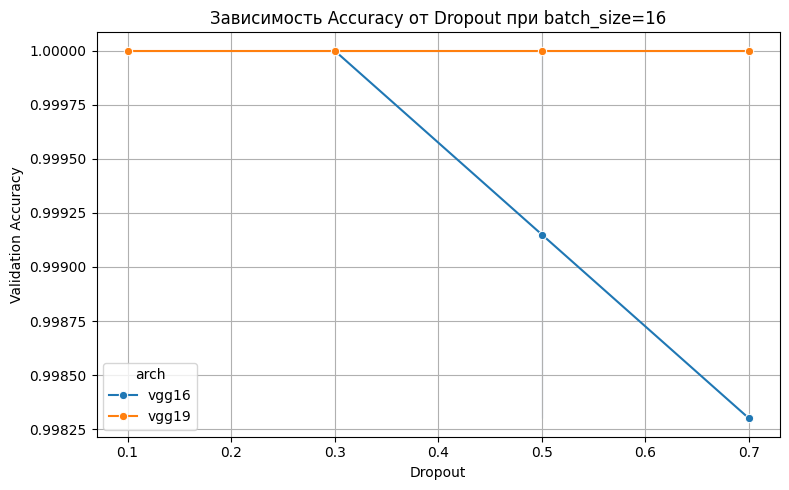

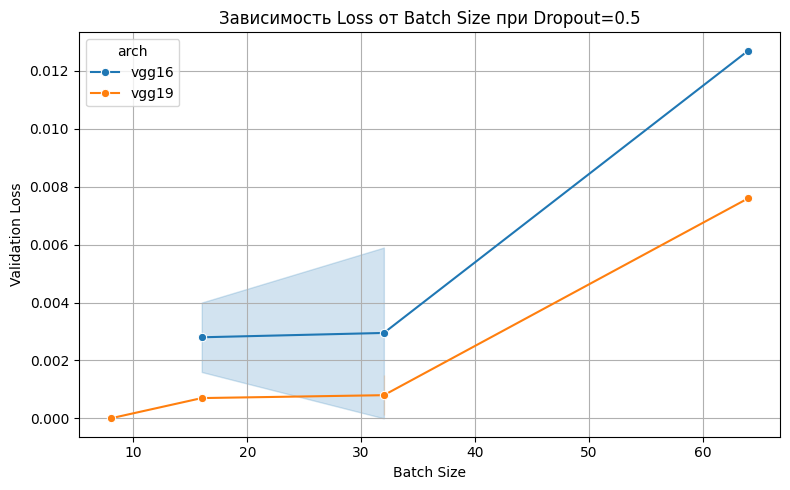

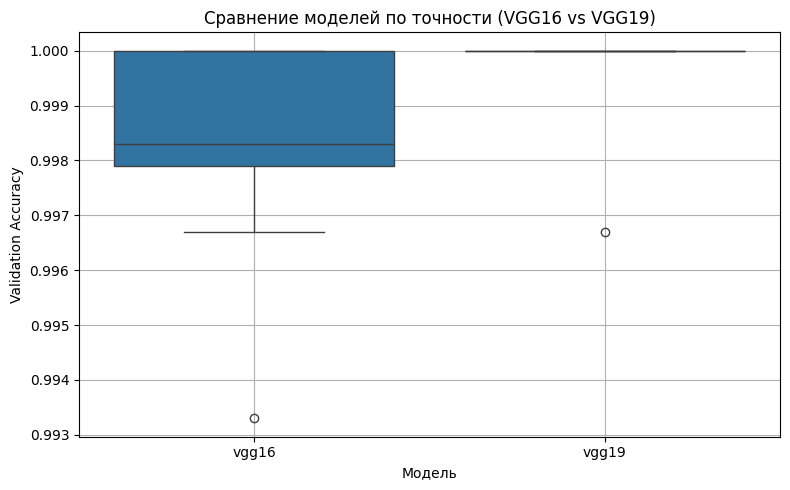

In [ ]:
# Повторная инициализация после сброса
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(raw_data, columns=[
    'arch', 'optimizer', 'lr', 'dropout', 'epochs', 'batch_size', 'val_accuracy', 'val_loss'
])

# --- График 1: Accuracy от Dropout (только batch_size=16)
plt.figure(figsize=(8, 5))
subset = df[df['batch_size'] == 16]
sns.lineplot(data=subset, x='dropout', y='val_accuracy', hue='arch', marker='o')
plt.title('Зависимость Accuracy от Dropout при batch_size=16')
plt.xlabel('Dropout')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- График 2: Loss от Batch Size (только dropout=0.5)
plt.figure(figsize=(8, 5))
subset = df[df['dropout'] == 0.5]
sns.lineplot(data=subset, x='batch_size', y='val_loss', hue='arch', marker='o')
plt.title('Зависимость Loss от Batch Size при Dropout=0.5')
plt.xlabel('Batch Size')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- График 3: Сравнение моделей VGG16 и VGG19 по Accuracy
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='arch', y='val_accuracy')
plt.title('Сравнение моделей по точности (VGG16 vs VGG19)')
plt.xlabel('Модель')
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()


### Исследование Layers CNN


In [ ]:
conv_configs = [
    ('light', [
        {'filters': 32, 'conv_layers': 1, 'use_bn': False, 'activation': 'relu', 'use_pooling': True},
        {'filters': 64, 'conv_layers': 1, 'use_bn': False, 'activation': 'relu', 'use_pooling': True}
    ]),
    ('moderate', [
        {'filters': 64, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 128, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': True}
    ]),
    ('heavy', [
        {'filters': 64, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 128, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 256, 'conv_layers': 3, 'use_bn': True, 'activation': 'relu', 'use_pooling': True}
    ])
]
results_custom_cnn = []
for name, config in conv_configs:
    res = custom_run_experiment(config)
    results_custom_cnn.append(res)


Завершено: {'Конфигурация': 'light', 'val_accuracy': 0.995, 'val_loss': 0.013505, 'timestamp': datetime.datetime(2025, 5, 30, 12, 59, 35, 281174)}
Завершено: {'Конфигурация': 'moderate', 'val_accuracy': 0.996667, 'val_loss': 0.012161, 'timestamp': datetime.datetime(2025, 5, 30, 13, 20, 56, 246628)}
Завершено: {'Конфигурация': 'heavy', 'val_accuracy': 1.0, 'val_loss': 0.00017, 'timestamp': datetime.datetime(2025, 5, 30, 13, 51, 49, 732875)}


AttributeError: module 'pandas' has no attribute 'Dataframe'

In [ ]:
df = pd.DataFrame(results_custom_cnn)

#### Изменение функции активации на Leaky ReLu

In [ ]:
# from tensorflow.keras.activations import leaky_relu
import pandas as pd

conv_configs = [
    ('light', [
        {'filters': 32, 'conv_layers': 1, 'use_bn': False, 'activation': 'leaky_relu', 'use_pooling': True},
        {'filters': 64, 'conv_layers': 1, 'use_bn': False, 'activation': 'leaky_relu', 'use_pooling': True}
    ]),
    ('moderate', [
        {'filters': 64, 'conv_layers': 2, 'use_bn': True, 'activation': 'leaky_relu', 'use_pooling': True},
        {'filters': 128, 'conv_layers': 2, 'use_bn': True, 'activation': 'leaky_relu', 'use_pooling': True}
    ]),
    ('heavy', [
        {'filters': 64, 'conv_layers': 2, 'use_bn': True, 'activation': 'leaky_relu', 'use_pooling': True},
        {'filters': 128, 'conv_layers': 2, 'use_bn': True, 'activation': 'leaky_relu', 'use_pooling': True},
        {'filters': 256, 'conv_layers': 3, 'use_bn': True, 'activation': 'leaky_relu', 'use_pooling': True}
    ])
]
results_custom_cnn_activation_leakyrlu = []
for name, config in conv_configs:
    res = custom_run_experiment(config)
    results_custom_cnn_activation_leakyrlu.append(res)



Завершено: {'Конфигурация': 'light', 'val_accuracy': 0.986667, 'val_loss': 0.031, 'timestamp': datetime.datetime(2025, 6, 2, 8, 8, 56, 253085)}
Завершено: {'Конфигурация': 'moderate', 'val_accuracy': 0.998333, 'val_loss': 0.012335, 'timestamp': datetime.datetime(2025, 6, 2, 8, 25, 36, 915790)}
Завершено: {'Конфигурация': 'heavy', 'val_accuracy': 0.99, 'val_loss': 0.06601, 'timestamp': datetime.datetime(2025, 6, 2, 8, 51, 54, 750690)}


NameError: name 'pd' is not defined

In [ ]:
import pandas as pd

df = pd.DataFrame(results_custom_cnn_activation_leakyrlu)
df

,Конфигурация,val_accuracy,val_loss,timestamp
0,light,0.986667,0.031000,2025-06-02 08:08:56.253085
1,moderate,0.998333,0.012335,2025-06-02 08:25:36.915790
2,heavy,0.990000,0.066010,2025-06-02 08:51:54.750690


#### Изменение pooling to False

In [ ]:
import pandas as pd

conv_configs = [
    ('light', [
        {'filters': 32, 'conv_layers': 1, 'use_bn': False, 'activation': 'relu', 'use_pooling': False},
        {'filters': 64, 'conv_layers': 1, 'use_bn': False, 'activation': 'relu', 'use_pooling': False}
    ]),
    ('moderate', [
        {'filters': 64, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': False},
        {'filters': 128, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': False}
    ]),
    ('heavy', [
        {'filters': 64, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': False},
        {'filters': 128, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': False},
        {'filters': 256, 'conv_layers': 3, 'use_bn': True, 'activation': 'relu', 'use_pooling': False}
    ])
]
results_custom_cnn_pooling = []
for name, config in conv_configs:
    res = custom_run_experiment(config)
    results_custom_cnn_pooling.append(res)

df = pd.DataFrame(results_custom_cnn_pooling)
df

Завершено: {'Конфигурация': 'light', 'val_accuracy': 0.993333, 'val_loss': 0.026143, 'timestamp': datetime.datetime(2025, 6, 2, 9, 26, 48, 222069)}
Завершено: {'Конфигурация': 'moderate', 'val_accuracy': 0.998333, 'val_loss': 0.053972, 'timestamp': datetime.datetime(2025, 6, 2, 10, 53, 47, 43679)}


In [ ]:
import pandas as pd

conv_configs = [
    ('light', [
        {'filters': 8, 'conv_layers': 1, 'use_bn': False, 'activation': 'relu', 'use_pooling': True},
        {'filters': 16, 'conv_layers': 1, 'use_bn': False, 'activation': 'relu', 'use_pooling': True}
    ]),
    ('moderate', [
        {'filters': 16, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 32, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': True}
    ]),
    ('heavy', [
        {'filters': 16, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 32, 'conv_layers': 2, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 64, 'conv_layers': 3, 'use_bn': True, 'activation': 'relu', 'use_pooling': True}
    ])
]

results_custom_cnn_less_filters = []
for name, config in conv_configs:
    res = custom_run_experiment(config)
    results_custom_cnn_less_filters.append(res)

df = pd.DataFrame(results_custom_cnn_less_filters)
df

Завершено: {'Конфигурация': 'light', 'val_accuracy': 0.988333, 'val_loss': 0.043555, 'timestamp': datetime.datetime(2025, 6, 2, 10, 59, 12, 132671)}
Завершено: {'Конфигурация': 'moderate', 'val_accuracy': 0.998333, 'val_loss': 0.008132, 'timestamp': datetime.datetime(2025, 6, 2, 11, 2, 23, 650821)}
Завершено: {'Конфигурация': 'heavy', 'val_accuracy': 0.995, 'val_loss': 0.015606, 'timestamp': datetime.datetime(2025, 6, 2, 11, 6, 31, 492558)}


,Конфигурация,val_accuracy,val_loss,timestamp
0,light,0.988333,0.043555,2025-06-02 10:59:12.132671
1,moderate,0.998333,0.008132,2025-06-02 11:02:23.650821
2,heavy,0.995000,0.015606,2025-06-02 11:06:31.492558


#### Исследование различных вариаций слоев

In [ ]:
import pandas as pd

conv_configs = [
    ('light', [
        {'filters': 8, 'conv_layers': 2, 'use_bn': False, 'activation': 'relu', 'use_pooling': True},
        {'filters': 16, 'conv_layers': 2, 'use_bn': False, 'activation': 'relu', 'use_pooling': True}
    ]),
    ('moderate', [
        {'filters': 16, 'conv_layers': 4, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 32, 'conv_layers': 4, 'use_bn': True, 'activation': 'relu', 'use_pooling': True}
    ]),
    ('heavy', [
        {'filters': 16, 'conv_layers': 4, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 32, 'conv_layers': 4, 'use_bn': True, 'activation': 'relu', 'use_pooling': True},
        {'filters': 64, 'conv_layers': 5, 'use_bn': True, 'activation': 'relu', 'use_pooling': True}
    ])
]

results_custom_cnn_less_filters_x2conv = []
for name, config in conv_configs:
    res = custom_run_experiment(config)
    results_custom_cnn_less_filters_x2conv.append(res)

df = pd.DataFrame(results_custom_cnn_less_filters_x2conv)
df

Завершено: {'Конфигурация': 'light', 'val_accuracy': 0.993333, 'val_loss': 0.023744, 'timestamp': datetime.datetime(2025, 6, 2, 11, 9, 34, 226768)}
Завершено: {'Конфигурация': 'moderate', 'val_accuracy': 0.995, 'val_loss': 0.027461, 'timestamp': datetime.datetime(2025, 6, 2, 11, 16, 8, 347376)}
Завершено: {'Конфигурация': 'heavy', 'val_accuracy': 0.998333, 'val_loss': 0.006585, 'timestamp': datetime.datetime(2025, 6, 2, 11, 23, 11, 291172)}


,Конфигурация,val_accuracy,val_loss,timestamp
0,light,0.993333,0.023744,2025-06-02 11:09:34.226768
1,moderate,0.995000,0.027461,2025-06-02 11:16:08.347376
2,heavy,0.998333,0.006585,2025-06-02 11:23:11.291172


### Слои Все в одной таблице  

In [ ]:
import pandas as pd

# Все данные экспериментов
data = [
    ('relu + pool + std filters', 'light', 0.995, 0.013505),
    ('relu + pool + std filters', 'moderate', 0.996667, 0.012161),
    ('relu + pool + std filters', 'heavy', 1.0, 0.00017),

    ('leaky_relu + pool + std filters', 'light', 0.986667, 0.031),
    ('leaky_relu + pool + std filters', 'moderate', 0.998333, 0.012335),
    ('leaky_relu + pool + std filters', 'heavy', 0.99, 0.06601),

    ('relu + no pool + std filters', 'light', 0.993333, 0.026143),
    ('relu + no pool + std filters', 'moderate', 0.998333, 0.053972),

    ('relu + pool + small filters', 'light', 0.988333, 0.043555),
    ('relu + pool + small filters', 'moderate', 0.998333, 0.008132),
    ('relu + pool + small filters', 'heavy', 0.995, 0.015606),

    ('relu + pool + deep conv', 'light', 0.993333, 0.023744),
    ('relu + pool + deep conv', 'moderate', 0.995, 0.027461),
    ('relu + pool + deep conv', 'heavy', 0.998333, 0.006585),
]

df = pd.DataFrame(data, columns=[
    'Конфигурация', 'Тип модели', 'val_accuracy', 'val_loss'
])

df = df.sort_values(by=['Конфигурация', 'Тип модели']).reset_index(drop=True)
df

,Конфигурация,Тип модели,val_accuracy,val_loss
0,leaky_relu + pool + std filters,heavy,0.990000,0.066010
1,leaky_relu + pool + std filters,light,0.986667,0.031000
2,leaky_relu + pool + std filters,moderate,0.998333,0.012335
3,relu + no pool + std filters,light,0.993333,0.026143
4,relu + no pool + std filters,moderate,0.998333,0.053972
5,relu + pool + deep conv,heavy,0.998333,0.006585
6,relu + pool + deep conv,light,0.993333,0.023744
7,relu + pool + deep conv,moderate,0.995000,0.027461
8,relu + pool + small filters,heavy,0.995000,0.015606
9,relu + pool + small filters,light,0.988333,0.043555


# COVID-19 Dataset

In [ ]:
extract_path = "/content/dataset/"
zip_path = "/content/Archive-Death.zip"

In [ ]:
import zipfile
import os

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Архив успешно распакован в:", extract_path)

Архив успешно распакован в: /content/dataset/


In [ ]:
import pandas as pd


df = pd.read_csv(f'{extract_path}Covid Data.csv')
df

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


In [ ]:
df['fact_death'] = df['DATE_DIED'].apply(lambda x: 2 if x != '9999-99-99' else 1)

df['fact_death']

,fact_death
0,2
1,2
2,2
3,2
4,2
...,...
1048570,1
1048571,1
1048572,1
1048573,1


In [ ]:
features = ['AGE', 'SEX', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA',
            'INMSUPR', 'HIPERTENSION', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
X = df[features]
y = df['fact_death']
X = X.fillna(0)
X

,AGE,SEX,PNEUMONIA,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OBESITY,RENAL_CHRONIC,TOBACCO
0,65,1,1,2,2,2,2,1,2,2,2
1,72,2,1,2,2,2,2,1,1,1,2
2,55,2,2,1,2,2,2,2,2,2,2
3,53,1,2,2,2,2,2,2,2,2,2
4,68,2,2,1,2,2,2,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
1048570,40,2,2,2,2,2,2,2,2,2,2
1048571,51,2,2,2,2,2,2,1,2,2,2
1048572,55,2,2,2,2,2,2,2,2,2,2
1048573,28,2,2,2,2,2,2,2,2,2,2


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=56546
)

len(X_train)

838860

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[-0.87554192,  1.00120951, -0.11359952, ..., -0.0242587 ,
        -0.05015753, -0.04042746],
       [-0.46154963, -0.99879195, -0.11359952, ..., -0.0242587 ,
        -0.05015753, -0.04042746],
       [ 1.60841181,  1.00120951, -0.19721658, ..., -0.0242587 ,
        -0.05015753, -0.22767302],
       ...,
       [-0.69811665,  1.00120951, -0.11359952, ..., -0.0242587 ,
        -0.05015753, -0.04042746],
       [-1.11210894,  1.00120951, -0.11359952, ..., -0.0242587 ,
        -0.05015753, -0.04042746],
       [ 0.07072617,  1.00120951, -0.11359952, ..., -0.0242587 ,
        -0.05015753, -0.04042746]])

## Аугментация

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=88781)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [ ]:
len(X_train_res)

1554612

## Построение модели и функция запуска экспериментов

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD

def create_tabular_model(hidden_layers=[64, 32], activation='relu',
                         dropout_rate=0.3, lr=1e-3, optimizer='adam'):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation=activation, input_shape=(len(features),)))
    model.add(Dropout(dropout_rate))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    opt = Adam(learning_rate=lr) if optimizer=='adam' else SGD(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def run_exp(config):
    model = create_tabular_model(
        hidden_layers=config['layers'],
        activation=config['activation'],
        dropout_rate=config['dropout'],
        lr=config['lr'],
        optimizer=config['opt']
    )
    history = model.fit(X_train_res, y_train_res, validation_data=(X_test, y_test),
                        epochs=config['epochs'], batch_size=config['batch_size'], verbose=0)
    acc = history.history['val_accuracy'][-1]
    loss = history.history['val_loss'][-1]
    return {**config,
            'val_accuracy': round(acc,6),
            'val_loss': round(loss,6)
            }


## Запуск экспериментов

In [ ]:
experiments = [
    {
        'layers':[64,32],
        'activation':'relu',
        'dropout':0.3,
        'lr':1e-3,
        'opt':'adam',
        'epochs': 10,
        'batch_size':64
    },
    {
        'layers':[128,64],
        'activation':'relu',
        'dropout':0.3,
        'lr':1e-4,
        'opt':'adam',
        'epochs':10,
        'batch_size':64
    },
    {
        'layers':[64,32],
        'activation':'tanh',
        'dropout':0.5,
        'lr':1e-3,
        'opt':'sgd',
        'epochs':10,
        'batch_size':64
    },
    {
        'layers':[16,8],
        'activation':'leaky_relu',
        'dropout':0.3,
        'lr':1e-3,
        'opt':'adam',
        'epochs':10,
        'batch_size':64
    },
    {
        'layers':[16,8],
        'activation':'leaky_relu',
        'dropout':0.3,
        'lr':1e-3,
        'opt':'adam',
        'epochs':10,
        'batch_size':16
    },
]

results = [run_exp(cfg) for cfg in experiments]
import pandas as pd
pd.DataFrame(results)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


,layers,activation,dropout,lr,opt,epochs,batch_size,val_accuracy,val_loss
0,"[64, 32]",relu,0.3,0.0010,adam,10,64,0.926624,-4.770966e+09
1,"[128, 64]",relu,0.3,0.0001,adam,10,64,0.926624,-1.467636e+07
2,"[64, 32]",tanh,0.5,0.0010,sgd,10,64,0.926624,-2.928308e+02
3,"[16, 8]",leaky_relu,0.3,0.0010,adam,10,64,0.707093,-2.049252e+08
4,"[16, 8]",leaky_relu,0.3,0.0010,adam,10,16,0.752216,-7.930603e+09
